In [ ]:
'''
I made this encoder as a way to weight wrong predictions, basically make some directions 
more wrong than others.
If it is south and it guesses SSE, it is less wrong than if it Guessed north


'''

In [ ]:
def cool_encoder(image, num_classes, height, width):
    empty = np.zeros((num_classes, height, width))
    for i in range(num_classes):
        np.place(empty[i], image==i, 1)
        if i > 5 and i < 16:
            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i-1, 0.75)
            np.place(empty[i], image==i+2, 0.5)
            np.place(empty[i], image==i-2, 0.5)
            np.place(empty[i], image==i+3, 0.3)
            np.place(empty[i], image==i-3, 0.3)
        elif i == 3:
            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i+2, 0.5)
            np.place(empty[i], image==i+3, 0.3)

        elif i == 4:
            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i+2, 0.5)
            np.place(empty[i], image==i+3, 0.3)
            np.place(empty[i], image==i-1, 0.75)
        elif i == 5:
            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i+2, 0.5)
            np.place(empty[i], image==i+3, 0.3)
            np.place(empty[i], image==i-1, 0.75)
            np.place(empty[i], image==i-2, 0.5)

        elif i == 16:

            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i+2, 0.5)
            np.place(empty[i], image==i-1, 0.75)
            np.place(empty[i], image==i-2, 0.5)
            np.place(empty[i], image==i-3, 0.3)

        elif i == 17:
            np.place(empty[i], image==i+1, 0.75)
            np.place(empty[i], image==i+3, 0.3)
            np.place(empty[i], image==i-2, 0.5)
            np.place(empty[i], image==i-1, 0.75)
               
        elif i == 18:
            np.place(empty[i], image==i-1, 0.75)
            np.place(empty[i], image==i-2, 0.5)
            np.place(empty[i], image==i+3, 0.3)

           
    return empty
cool_encoder(image, 20, 512, 512)

In [1]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet34(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [3]:
PATH = "model91r.pt"
model = torch.load(PATH)
model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [4]:
img1 = imageio.imread('/home/kyle/deeproof(1)/deeproof-release/src/roof0256.jpg')
img2 = imageio.imread('/home/kyle/deeproof(1)/deeproof-release/src/roof1256.jpg')
img3 = imageio.imread('/home/kyle/deeproof(1)/deeproof-release/src/roof2256.jpg')

ten1 = torch.tensor(img1)
ten2 = torch.tensor(img2)
ten3 = torch.tensor(img3)


In [7]:
import torch

model = ResNetUNet(20)


In [8]:
model = ResNetUNet(20)

model.load_state_dict(torch.load('model91d.pt'))

<All keys matched successfully>

In [11]:
model.eval()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [86]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model = ResNetUNet(20)
model.load_state_dict(torch.load('model91d.pt'))
model.eval()


ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
from PIL import Image

In [107]:
img = image_loader(data_transforms, '/home/kyle/deeproof(1)/deeproof-release/data/deeproof-aug/small-images/522749539.0.jpg')

/home/kyle/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
out = model(img)

In [ ]:
arrgm = torch.argmax(out[0,:],0)

In [111]:
def pix_per_class(img):
    """returns unique dictionary with class numbers for keys and number of pixels per class as values"""
    unique, counts = np.unique(img, return_counts=True)
    unique = [int(i) for i in unique]
    act_classes = dict(zip(unique, counts))
    
    return act_classes

In [114]:
pix_per_class(arrgm)

{0: 39517,
 1: 5428,
 3: 142,
 4: 3,
 5: 62,
 6: 206,
 7: 915,
 8: 480,
 9: 133,
 10: 102,
 11: 570,
 12: 39,
 13: 144,
 14: 242,
 15: 1782,
 16: 240,
 17: 54,
 19: 15477}

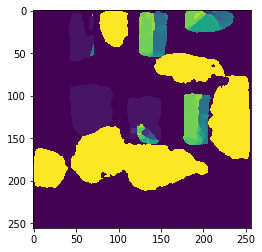

In [115]:
plt.imshow(arrgm)

In [69]:
out[0,:].shape

torch.Size([20, 256, 256])

In [70]:
import matplotlib.pyplot as plt

#### 
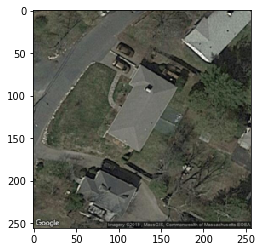

### 50 epochs 256 with normalization

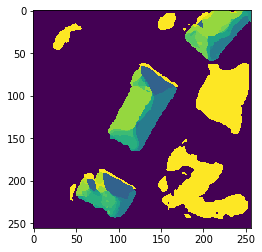

### 256 w/o reg
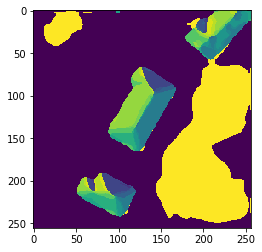

#### 
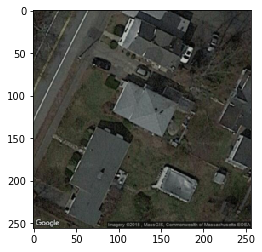

## 
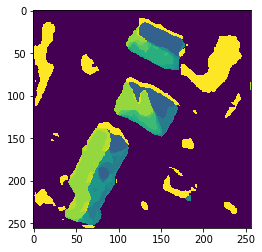

### 256 w/o reg
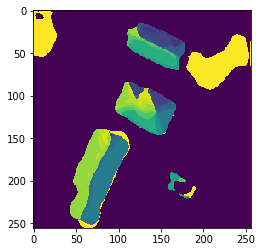

#### 
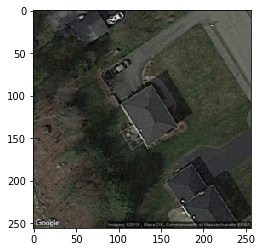

### 
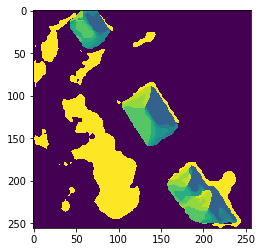

### 256 w/o reg
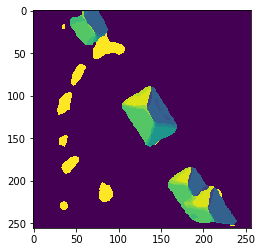

In [12]:

    tensor = transform_image(image_bytes=image_bytes)
    my_model = torch.load('full-res-92.pkl', map_location=torch.device('cpu'))
    outputs = my_model['model'](tensor)
    out = torch.argmax(outputs,dim=1)
    model_out_array = out.numpy()


NameError: name 'Variable' is not defined